In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [14]:
import os
import json
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_core.messages import ToolMessage

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [15]:
tool = TavilySearch(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4.1", openai_api_key=OPENAI_API_KEY)
llm_with_tools = llm.bind_tools(tools)

In [16]:
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if (messages := inputs.get("messages")):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            ))
        return {"messages": outputs}
        
tool_node = BasicToolNode(tools)

In [17]:
def route_tools(state: State) -> State:
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError("No AI message found in state")
    if ai_message.tool_calls:
        return "tool_node"
    return END


In [18]:
def chatbot(state: State) -> State:
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


graph_builder = StateGraph(State)
graph_builder.add_node("tool_node", tool_node)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tool_node": "tool_node", END: END},
)
graph_builder.add_edge("tool_node", "chatbot")

graph = graph_builder.compile()

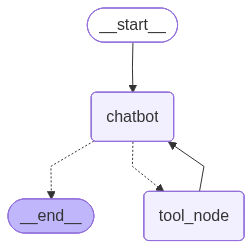

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [20]:
def stream_chatbot(user_input:str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("assistant: ", value["messages"][-1].content)

while True:
    try: 
        user_input = input("User: ")
        if user_input.lower() in ["exit", "quit"]:
            print("Exiting...")
            break
        stream_chatbot(user_input)

    except:
        user_input = "User: How is the industry adoption of LangGraph and LangChain?"
        print(user_input)
        stream_chatbot(user_input)
        break


assistant:  **LangGraph** and **LangChain** are two frameworks developed in the past year to facilitate interaction with and orchestration of Large Language Models (LLMs), particularly to build complex, multi-step, and multi-agent workflows. They compete (and sometimes complement) with other orchestration frameworks and agentic toolkits such as:

- **LlamaIndex**
- **Guardrails.ai**
- **Haystack**
- **CrewAI**
- **OpenAI Functions / Assistant API**
- **Autogen** (Microsoft)
- **Semantic Kernel** (Microsoft)
- **Flowise**
- **Dust.tt**
- **DSPy**

Let's break down the current **industry adoption** of LangGraph and LangChain in this broader context.

---

## **LangChain**

### **Adoption**
- **LangChain** is arguably the most widely adopted orchestration framework for LLMs as of early 2024.
- **Backing & Community**: It has strong VC funding, extensive open-source community support, and a vast ecosystem of plugins, integrations, and tutorials.
- **Industry Use**: Startups, research labs,